
# Dog breed classification 

CNN based on [lesson 2](http://course.fast.ai/lessons/lesson2.html) of the deep learning fast.ai course, with data from the Kaggle Competition [dog-breed-identification](https://www.kaggle.com/c/dog-breed-identification).

This excercise follows the lesson's steps to train a world class classification model:

1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
# See http://forums.fast.ai/t/torch-cuda-is-available-returns-false/16721/8
# And https://aws.amazon.com/blogs/machine-learning/get-started-with-deep-learning-using-the-aws-deep-learning-ami/
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

`PATH` is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. `sz` is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at `224` for now.

In [6]:
# ! dir ..\..\..\Github\data\dog-breed-identification

In [7]:
PATH = "..\\..\\..\\Github\\data\\dog-breed-identification\\"

## Initial Exploration

In [8]:
# os.listdir(PATH)
# ! ls {PATH}
! dir {PATH}

 El volumen de la unidad C es OS
 El número de serie del volumen es: 803A-128D

 Directorio de C:\Users\ANALISTA\Github\data\dog-breed-identification

05/06/2018  05:13 p.m.    <DIR>          .
05/06/2018  05:13 p.m.    <DIR>          ..
28/09/2017  03:38 p.m.           482.063 labels.csv
05/06/2018  04:51 p.m.           218.954 labels.csv.zip
06/06/2018  07:39 a.m.           246.218 sample_labels.csv
28/09/2017  03:38 p.m.        25.200.295 sample_submission.csv
05/06/2018  04:51 p.m.           288.160 sample_submission.csv.zip
28/09/2017  03:43 p.m.    <DIR>          test
05/06/2018  04:57 p.m.       362.738.853 test.zip
05/06/2018  05:13 p.m.    <DIR>          tmp
28/09/2017  03:43 p.m.    <DIR>          train
05/06/2018  04:57 p.m.       361.279.070 train.zip
               7 archivos    750.453.613 bytes
               5 dirs  838.105.980.928 bytes libres


In [9]:
os.listdir(f'{PATH}train')[:5]

['000bec180eb18c7604dcecc8fe0dba07.jpg',
 '001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '001cdf01b096e06d78e9e5112d419397.jpg',
 '00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [10]:
labels_df = pd.read_csv(PATH + 'labels.csv')
print('There are', len(labels_df), 'training observations, and',
      len(os.listdir(f'{PATH}test')), 'test observations.')
labels_df.sample(5)

There are 10222 training observations, and 10357 test observations.


,id,breed
803,13e608df9c88b1465ebf98bc84d0a832,bedlington_terrier
3957,622f0b4067275a67f8471b2e945e21e0,black-and-tan_coonhound
756,12c65c69fa9e112448f7d26ed34abb57,saluki
9699,f3f295d33149977b1d67b8a3b6484ea7,mexican_hairless
9953,f9f2c52b196c9da8c7c98c68003d4f08,schipperke


In [11]:
labels_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


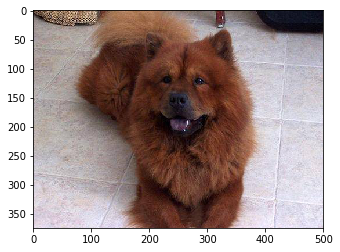

In [12]:
img = plt.imread(PATH + 'train/' + labels_df.sample(1)['id'].values[0] + '.jpg')
plt.imshow(img)

### Sample subset of images (for cpu only)

In [13]:
frac = 0.5
sample_labels_df = labels_df.sample(frac=frac).set_index('id')
sample_labels_df.to_csv(PATH + 'sample_labels.csv')

In [14]:
sample_labels_df

,breed
id,
f9eedeff3a54f28301468decc50e3def,curly-coated_retriever
527f2edcc29f3e3e31c57728e6ec9e59,bouvier_des_flandres
28353e057b0f67d44cb95baa708688d8,collie
e25accfed48409094b7c56c6a92395ad,brabancon_griffon
b5184cf2fb46e3bdc8a3d4910713da92,scotch_terrier
c182aec9722d11b6cd64933aa33b932d,japanese_spaniel
55ca8f686661259ab4272e2a0aa22066,maltese_dog
2a26dd719f6ab87fc13eb834d9a9f8e6,toy_terrier
65ed1dfcfc3e6b24ab18550b866c9369,airedale


# Model

In [15]:
# Image size to feed into the model.  If the original images do not correspond to this size, thei are center cropped.
sz = 224

arch = resnext101_64  # resnet34  # Model architecture.
bs = 64  # Batch size


n = len(sample_labels_df)  # len(list(open(PATH + 'labels.csv'))) - 1
val_idxs = get_cv_idxs(n, val_pct=0.2)

In [16]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(path=PATH, folder='train', csv_fname=PATH + 'sample_labels.csv',
                                    test_name='test', suffix='.jpg', val_idxs=val_idxs, tfms=tfms, bs=bs)

In [17]:
fn = PATH + data.trn_ds.fnames[10]; fn

'..\\..\\..\\Github\\data\\dog-breed-identification\\train\\008b1271ed1addaccf93783b39deab45.jpg'

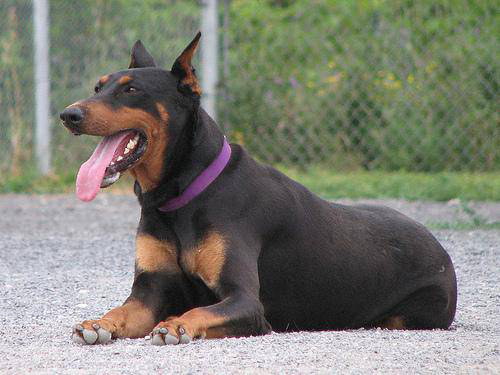

In [18]:
img = PIL.Image.open(fn); img

In [19]:
img.size

(500, 375)

In [20]:
sizes_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*sizes_d.values()))
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

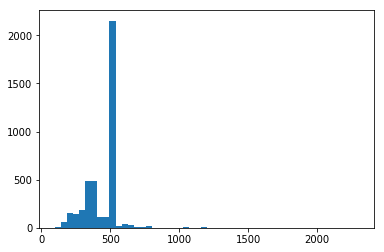

In [21]:
plt.hist(row_sz, bins = 50);  # semi-colon for not printing the bins of the histogram.

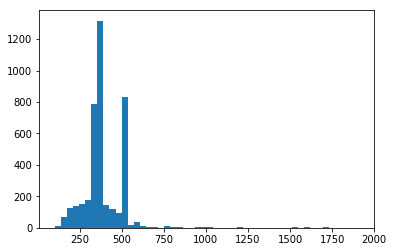

In [22]:
plt.hist(col_sz, bins = 50);

## 1. Enable data augmentation, and precompute=True

### Initial Model

The following function helps iterate faster with the model.  It receives the image's size (`sz`) and the batch size (`bs`).

1. Start with small sizes (eg. 64) for fast computing at the beginning.  Then increase the size.
1. If one runs out of memory, first **restart the kernel**, then decrease the batch size.


In [23]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(path=PATH, folder='train', csv_fname=PATH + 'sample_labels.csv',
                                        test_name='test', suffix='.jpg', val_idxs=val_idxs, tfms=tfms, bs=bs)
    return data if sz > 300 else data.resize(340, 'tmp')

In [24]:
sz = 128
bs = 64
data = get_data(sz, bs)

In [25]:
# See http://forums.fast.ai/t/dog-breed-challenge-precompute-error/10988/8
learn = ConvLearner.pretrained(arch, data, precompute=True)

C:\ProgramData\Anaconda3\envs\fastai\lib\site-packages\torch\cuda\__init__.py:116: UserWarning: 
    Found GPU0 NVS 310 which is of cuda capability 2.1.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


RuntimeError: cuda runtime error (48) : no kernel image is available for execution on the device at c:\anaconda2\conda-bld\pytorch_1519501749874\work\torch\lib\thc\generic/THCTensorMath.cu:15

In [ ]:
learn.save('pretrained_128')

In [ ]:
learn.fit(3e-1, 5)

In [ ]:
lrf = learn.lr_find()

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.sched.plot()